In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import scipy
import nltk
from scipy.sparse import coo_matrix, hstack
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

In [3]:
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from Levenshtein import distance

loo = LeaveOneOut()

In [4]:
train = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/train.csv')
test = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/test.csv')

In [5]:
df = train[train['query'] == 'bridal shower decorations']
df['product_description'].fillna('0', inplace=True)

C:\Users\Dindar\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
stop_words = set(stopwords.words('english')) 
df['query'] = df['query'].str.lower()
df['product_title'] = df['product_title'].str.lower()
df['product_description'] = df['product_description'].str.lower()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df['query'] = df['query'].apply(lemmatize_text)
df['product_title'] = df['product_title'].apply(lemmatize_text)
df['product_description'] = df['product_description'].apply(lemmatize_text)
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 = str1 + ' ' + ele      
    return str1[1:]
df['query'] = df['query'].apply(listToString)
df['product_title'] = df['product_title'].apply(listToString)
df['product_description'] = df['product_description'].apply(listToString)

C:\Users\Dindar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Dindar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dindar\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

# word2vec

In [5]:
import gensim

word2vec_path = "G:/Downloads/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [6]:
type(word2vec)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [7]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions,col, generate_missing=False):
    embeddings = clean_questions[col].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [8]:
df['product_title'] = df['product_title'].str.split()
df['product_description'] = df['product_description'].str.split()

C:\Users\Dindar\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Dindar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
embeddings = get_word2vec_embeddings(word2vec, df,'product_description')
embeddings1 = get_word2vec_embeddings(word2vec, df,'product_title')
embeddings = np.asarray(embeddings)
embeddings1 = np.asarray(embeddings1)
embeddings = pd.DataFrame(embeddings)
embeddings1 = pd.DataFrame(embeddings1)

In [129]:
embeddings['target'] = list(df['median_relevance'])
embeddings1['target1'] = list(df['median_relevance'])

In [130]:
a = pairwise.cosine_similarity(embeddings)
a = pd.DataFrame(a)

In [131]:
meann = []
maxx = []
minn = []
for i in a.index:
    iii = a.iloc[i].sort_values(ascending=False)[:6].index
    meann.append(embeddings.iloc[iii]['target'].mean())
    maxx.append(embeddings.iloc[iii]['target'].max())
    minn.append(embeddings.iloc[iii]['target'].min())
embeddings['mean_6_cos_word2vec'] = meann
embeddings['max_6_cos_word2vec'] = maxx
embeddings['min_6_cos_word2vec'] = minn

one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:6].index
    for j in embeddings.iloc[iii]['target']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
embeddings['one_6_cos_word2vec'] = one
embeddings['two_6_cos_word2vec'] = two
embeddings['three_6_cos_word2vec'] = three
embeddings['four_6_cos_word2vec'] = four

In [132]:
a = pairwise.cosine_similarity(embeddings1)
a = pd.DataFrame(a)

In [133]:
meann = []
maxx = []
minn = []
for i in a.index:
    iii = a.iloc[i].sort_values(ascending=False)[:3].index
    meann.append(embeddings1.iloc[iii]['target1'].mean())
    maxx.append(embeddings1.iloc[iii]['target1'].max())
    minn.append(embeddings1.iloc[iii]['target1'].min())
embeddings1['mean_3_cos_word2vec_title'] = meann
embeddings1['max_3_cos_word2vec_title'] = maxx
embeddings1['min_3_cos_word2vec_title'] = minn

In [134]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:3].index
    for j in embeddings1.iloc[iii]['target1']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
embeddings1['one_3_cos_word2vec_title'] = one
embeddings1['two_3_cos_word2vec_title'] = two
embeddings1['three_3_cos_word2vec_title'] = three
embeddings1['four_3_cos_word2vec_title'] = four

In [135]:
embeddings.shape, embeddings1.shape

((43, 308), (43, 308))

In [136]:
embeddings1.drop('target1',axis=1,inplace=True)

In [137]:
data = pd.concat([embeddings, embeddings1], axis=1)

In [7]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 7))
vectorizer1 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 7))
vectorizer2 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 7))

In [8]:
vectorizer3 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 4), analyzer='char')
X3 = vectorizer3.fit_transform(df['product_description'])

In [9]:
X1 = vectorizer1.fit_transform(df['product_title'])
X2 = vectorizer2.fit_transform(df['product_description'])

In [10]:
f1 = vectorizer1.get_feature_names()
f2 = vectorizer2.get_feature_names()
f3 = vectorizer3.get_feature_names()

In [11]:
tr = hstack([X1,X2,X3])

In [12]:
y = df['median_relevance']

In [178]:
tr

<43x15308 sparse matrix of type '<class 'numpy.float64'>'
	with 35260 stored elements in COOrdinate format>

In [48]:
data = pd.DataFrame(tr.A)
data['target'] = list(y)

In [96]:
svd = TruncatedSVD(n_components=4, random_state=42)
X_reduced1 = svd.fit_transform(tr)

In [14]:
tr.shape

(43, 15308)

In [15]:
X_reduced1.shape

(43, 5)

In [97]:
data = pd.DataFrame(X_reduced1)
data['target'] = list(y)

In [17]:
data.shape

(43, 6)

# cosine_similarity

In [144]:
a = pairwise.cosine_similarity(data.drop('target', axis=1).values)

In [145]:
a = pd.DataFrame(a)

In [146]:
meann = []
maxx = []
minn = []
for i in a.index:
    iii = a.iloc[i].sort_values(ascending=False)[:4].index
    meann.append(data.iloc[iii]['target'].mean())
    maxx.append(data.iloc[iii]['target'].max())
    minn.append(data.iloc[iii]['target'].min())
data['mean_4_cos'] = meann
data['max_4_cos'] = maxx
data['min_4_cos'] = minn

In [147]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    for j in data.iloc[iii]['target']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
data['one_4_cos'] = one
data['two_4_cos'] = two
data['three_4_cos'] = three
data['four_4_cos'] = four

# Levenshtein

In [98]:
df.set_index(pd.Index(list(range(43))), inplace=True)

In [99]:
a = []
for i in df.index:
    b = []
    for j in df.index:
        b.append(distance(df.iloc[i]['product_description'], df.iloc[j]['product_description']))
    a.append(b)

In [20]:
len(a)

43

In [100]:
a = np.asarray(a)
a = pd.DataFrame(a)

In [101]:
meann = []
maxx = []
minn = []
b = []
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index

    b.append(np.mean(a.iloc[i].iloc[iii]))
    meann.append(data.iloc[iii]['target'].mean())
    maxx.append(data.iloc[iii]['target'].max())
    minn.append(data.iloc[iii]['target'].min())
data['mean_4_lev'] = meann
data['max_4_lev'] = maxx
data['min_4_lev'] = minn
data['mean_dis_lev_4'] = b

In [88]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    for j in data.iloc[iii]['target']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
data['one_4_lev'] = one
data['two_4_lev'] = two
data['three_4_lev'] = three
data['four_4_lev'] = four

In [102]:
a = []
for i in df.index:
    b = []
    for j in df.index:
        b.append(distance(df.iloc[i]['product_title'], df.iloc[j]['product_title']))
    a.append(b)

In [103]:
a = np.asarray(a)
a = pd.DataFrame(a)

In [104]:
meann = []
maxx = []
minn = []
b = []
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    b.append(np.mean(a.iloc[i].iloc[iii]))
    meann.append(data.iloc[iii]['target'].mean())
    maxx.append(data.iloc[iii]['target'].max())
    minn.append(data.iloc[iii]['target'].min())
data['mean_4_lev_title'] = meann
data['max_4_lev_title'] = maxx
data['min_4_lev_title'] = minn
data['mean_dis_lev_4_title'] = b

In [92]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    for j in data.iloc[iii]['target']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
data['one_4_lev_title'] = one
data['two_4_lev_title'] = two
data['three_4_lev_title'] = three
data['four_4_lev_title'] = four

# jaccard_similarity

In [157]:
from distance import jaccard

In [158]:
a = []
for i in df.index:
    b = []
    for j in df.index:
        b.append(jaccard(df.iloc[i]['product_title'], df.iloc[j]['product_title']))
    a.append(b)

In [159]:
a = np.asarray(a)
a = pd.DataFrame(a)

In [160]:
meann = []
maxx = []
minn = []
b = []
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    b.append(np.mean(a.iloc[i].iloc[iii]))
    meann.append(data.iloc[iii]['target'].mean())
    maxx.append(data.iloc[iii]['target'].max())
    minn.append(data.iloc[iii]['target'].min())
data['mean_4_jar_title'] = meann
data['max_4_jar_title'] = maxx
data['min_4_jar_title'] = minn
data['mean_dis_jar_4_title'] = b

In [161]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:4].index
    for j in data.iloc[iii]['target']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1
data['one_4_jar_title'] = one
data['two_4_jar_title'] = two
data['three_4_jar_title'] = three
data['four_4_jar_title'] = four

# model

In [58]:
from catboost import CatBoostClassifier

In [105]:
X = data.drop(['target','min_4_lev_title','max_4_lev_title'],axis=1)
y = data['target']
weight = 1 / (1 + df['relevance_variance'])

In [106]:
%%time
y_ts = []
y_pr = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    w = weight.values[train_index]
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train, sample_weight=w)
    y_preds = xgb.predict(X_test)
    y_ts.append(y_test)
    y_pr.append(y_preds)

Wall time: 3.23 s


In [107]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# word2vec(avg) title(3), description(6,5) + sample weight, cos

0.5946582875098193

In [46]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# word2vec(avg) title(3), description(6,5) + sample weight, cos

0.5874668299652991

In [141]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# word2vec(avg) title(3), description(6) + sample weight, cos

0.95096921322691

In [234]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# desc char 1,4, compon = 5, iter = жок
                                                  # lev 4 descr, title
                                                  # data.drop(['target',3,4,'one_4_lev_title','one_4_lev','mean_4_lev']
                                                  # lev adding count features one, two, three, four

0.6401306389058992

In [225]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5, iter = жок
                                                  # lev 4 descr, title
                                                  # data.drop(['target',3,4,'one_4_lev_title', 'one_4_lev']
                                                  # lev adding count features one, two, three, four

0.6361804995970992

In [214]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5, iter = жок
                                                  # lev 4 descr, title
                                                  # data.drop(['target']
                                                  # lev adding count features one, two, three, four

0.631619937694704

In [192]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5, iter = жок
                                                  # lev 4 descr, title
                                                  # data.drop(['target']
                                                  # lev adding count features one, two, three, four 

0.5879131625268922

In [129]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5, iter = жок
                                                  # lev 4 + cos 4
                                                  # data.drop(['target',3,4]
                                                  # lev adding count features one, two, three, four 

0.6215529043614316

In [151]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5, iter = жок
                                                  # lev 4 + cos 4

0.594885598923284

In [129]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 5
                                                  # lev 4 + cos 4

0.5948174322732627

In [95]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 10
                                                  # lev 4 + cos 4

0.5945837512537613

In [70]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 10
                                                  # lev 4

0.5735681036227485

In [45]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 10
                                                  # lev 4 + cos 6

0.5876947662804635

In [36]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 10
                                                  # lev 3 + cos 6

0.5653251954987601

In [34]:
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# des char 1,4, compon = 10
                                                  # lev 3 

0.5675409189508973

In [142]:
X.columns

Index([             0,              1,              2,   'mean_5_nei',
          'max_5_nei',    'min_5_nei',   'mean_5_lev',    'max_5_lev',
          'min_5_lev', 'mean_dis_lev',    'one_4_lev',    'two_4_lev',
        'three_4_lev',   'four_4_lev'],
      dtype='object')

In [195]:
feature_imp = dict(zip(list(X.columns), list(xgb.feature_importances_)))

In [199]:
sorted_x = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)

In [33]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [47]:
xgb = XGBClassifier()
xgb.fit(X, y, sample_weight=weight)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

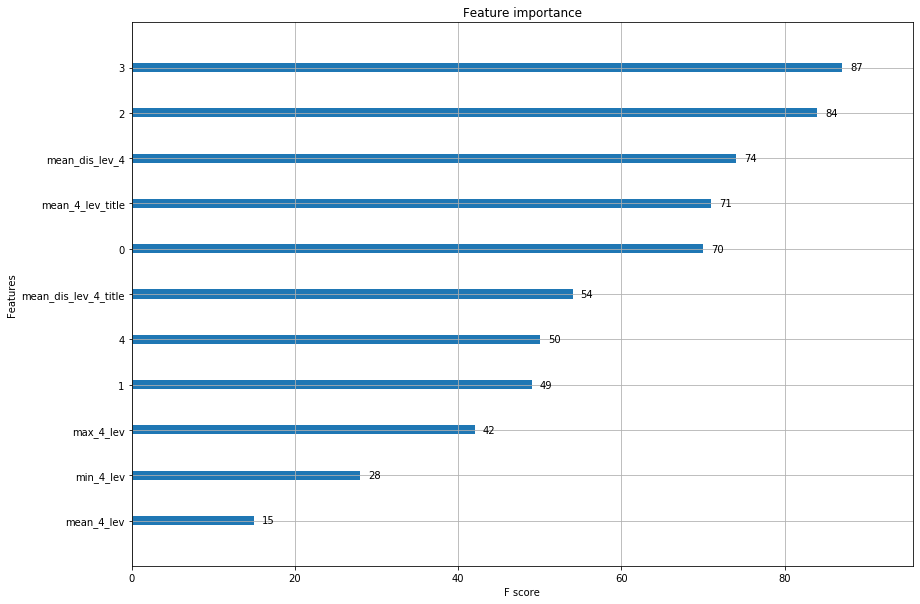

In [48]:
plot_features(xgb, (14,10))

In [35]:
X.columns

Index([                     0,                      1,                      2,
                 'mean_4_lev',            'max_4_lev',            'min_4_lev',
             'mean_dis_lev_4',     'mean_4_lev_title',      'max_4_lev_title',
            'min_4_lev_title', 'mean_dis_lev_4_title'],
      dtype='object')

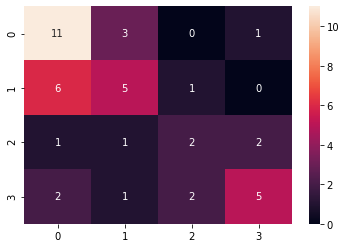

In [285]:
sns.heatmap(confusion_matrix(y_ts, y_pr), annot=True)